In [1]:
import numpy as np
import tensorflow as tf
np.random.seed(0)
tf.random.set_seed(0)

In [4]:
from tensorflow.keras import datasets
(X_tn0,y_tn0),(X_te0,y_te0) =datasets.mnist.load_data()#첫번째 버전이라 0

In [5]:
print(X_tn0.shape)
print(y_tn0.shape)
print(X_te0.shape)
print(y_te0.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


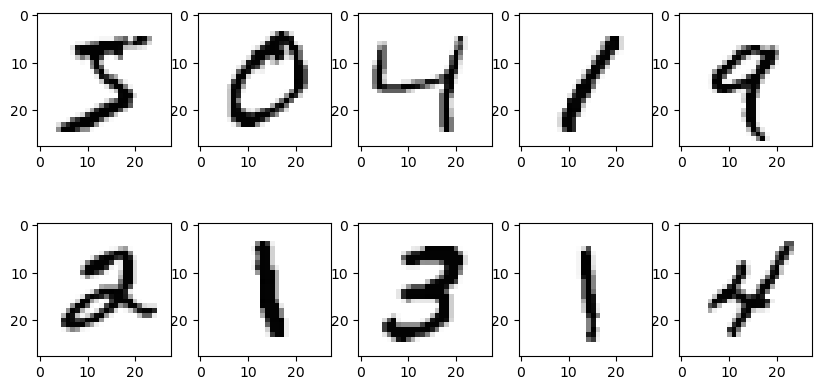

In [9]:
#오리지널 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
for i in range(2*5):
    plt.subplot(2,5,i+1)
    plt.imshow(X_tn0[i].reshape((28,28)),cmap='Greys')
plt.show()
    

In [10]:
set(y_tn0)#타깃 확인

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [14]:
X_tn_re=X_tn0.reshape(60000,28,28,1)#원래 이미지 개수, 행, 열 형태던 오리지널 데이터를 이미지 개수, 행, 열, 채널 수로 바꿔준다. (채널: RGB)
X_tn = X_tn_re/255 #이미지 픽셀 값의 최댓값이 1이 되면 성능이 좋음
print(X_tn.shape)
X_te_re=X_te0.reshape(10000,28,28,1)
X_te = X_te_re/255
print(X_te.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [16]:
from tensorflow.keras.utils import to_categorical
y_tn = to_categorical(y_tn0)
y_te = to_categorical(y_te0)

In [20]:
#CNN 생성
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import MaxPool2D, Flatten
from tensorflow.keras.layers import Dropout

n_class = len(set(y_tn0)) #클래스 개수 설정

model = Sequential()
model.add(Conv2D(32,kernel_size=(5,5),       #입력층. (아웃풋 데이터 차원(이미지 데이터 32개, 커널 사이즈, 
                input_shape=(28,28,1),       #인풋 데이터 차원= X_tn.shape의 행,열,채널
                padding='valid',             #패딩 옵션 선택 valid, same중 선택인데 vaild는 패딩 미실시, same은 패딩 실시로 입력 데이터와 동일하게 조정하겠다는 것
                activation='relu'))          #활성함수 relu

model.add(MaxPool2D(pool_size=(2,2)))        #다음층. 맥스폴링, 사이즈 지정

model.add(Dropout(0.25))                     # 드롭아웃. 입력되는 숫자는 사용하지 않은 노드의 비율

model.add(Conv2D(32,kernel_size=(3,3), 
                padding='valid',
                activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))

model.add(Flatten())                          # 최종 아웃풋 형태를 고려해 행렬 형태의 데이터를 Flatten을 이용하여 벡터 형태로 펼침

model.add(Dense(1024,activation='relu'))      #신경망 층 추가

model.add(Dropout(0.5))                       #드롭아웃

model.add(Dense(n_class,activation='softmax'))#활성화 함수를 소프트맥스 -> 최종 출력층

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 5, 5, 32)         

In [21]:
#모형 컴파일
model.compile(loss='categorical_crossentropy', #다중 분류 이므로 손실 함수 loss는 categorical_crossentropy
             optimizer='adam',                 #옵티마이저는 adam
             metrics=['accuracy'])             #모형의 성능 평가는 accuracy

In [22]:
#학습
hist = model.fit(X_tn,y_tn,epochs=3,batch_size=100)

Epoch 1/3


2024-01-24 17:00:50.058233: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


600/600 [==============================] - 11s 18ms/step - loss: 0.2173 - accuracy: 0.9327
Epoch 2/3
600/600 [==============================] - 12s 20ms/step - loss: 0.0720 - accuracy: 0.9781
Epoch 3/3
600/600 [==============================] - 12s 20ms/step - loss: 0.0566 - accuracy: 0.9819


In [24]:
print(model.evaluate(X_tn,y_tn)[1]) #[0]은 손실, [1]은 정확도...
print(model.evaluate(X_te,y_te)[1])

1875/1875 [==============================] - 7s 4ms/step - loss: 0.0243 - accuracy: 0.9926
0.9926499724388123
313/313 [==============================] - 1s 3ms/step - loss: 0.0249 - accuracy: 0.9921
0.9921000003814697


In [27]:
#오답 데이터 확인
y_pred_hot=model.predict(X_te)
print(y_pred_hot[0])

import numpy as np
y_pred=np.argmax(y_pred_hot,axis=1)#원 핫 인코딩을 통해 라벨링 된 타겟들을 원본 숫자 형태로 바꿈
print(y_pred)

diff=y_te0-y_pred #예측값과 실제값의 차이를 구함
diff_idx=[]       #실젯값과 예측값의 차이가 0이 아닌 인덱스를 저장할 용도.
y_len=len(y_te0)
for i in range(0,y_len):
    if(diff[i]!=0):
        diff_idx.append(i)

313/313 [==============================] - 1s 3ms/step
[4.6589639e-09 1.5437877e-07 6.3578909e-07 1.9061890e-05 3.0016225e-09
 2.3725425e-08 7.9274044e-12 9.9997354e-01 1.2668393e-07 6.3881066e-06]
[7 2 1 ... 4 5 6]


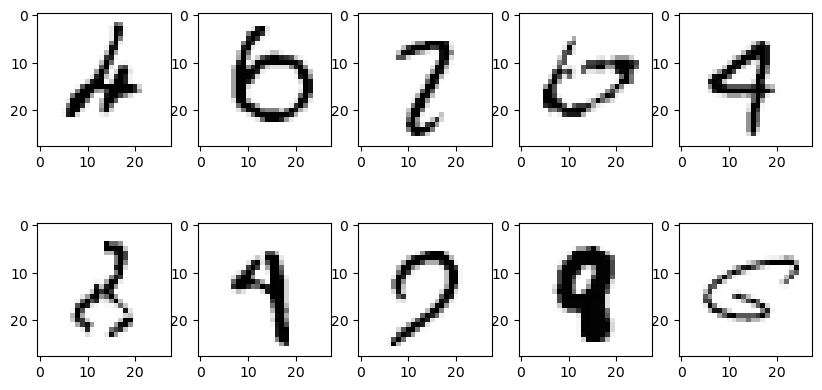

In [28]:
#오답 데이터 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
for i in range(2*5):
    plt.subplot(2,5,i+1)
    raw_idx = diff_idx[i]
    plt.imshow(X_te0[raw_idx].reshape((28,28)),
              cmap='Greys')
plt.show()